# Fine-tuning Stable Diffusion with DreamBooth

## Learning Objectives
- aaa

## Introduction

In this example, we implement DreamBooth, a fine-tuning technique to teach new visual concepts to text-conditioned Diffusion models with just 3 - 5 images. 

DreamBooth was proposed in [DreamBooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation](https://arxiv.org/abs/2208.12242) by Ruiz et al.

DreamBooth, in a sense, is similar to the
[traditional way of fine-tuning a text-conditioned Diffusion model except](https://keras.io/examples/generative/finetune_stable_diffusion/) for a few gotchas. This example assumes that you have basic familiarity with Diffusion models and how to fine-tune them. Here are some reference examples that might help you to get familiarized quickly:

* [High-performance image generation using Stable Diffusion in KerasCV](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/)
* [Teach StableDiffusion new concepts via Textual Inversion](https://keras.io/examples/generative/fine_tune_via_textual_inversion/)
* [Fine-tuning Stable Diffusion](https://keras.io/examples/generative/finetune_stable_diffusion/)

First, let's install the latest versions of KerasCV and TensorFlow.

In [1]:
# Remove comment out and install.
# !pip install --user keras-cv==0.5.1

If you're running the code, please ensure you're using a GPU with at least 24 GBs of
VRAM.

In [2]:
PROJECT = !gcloud config get-value project  # noqa: E999
PROJECT = PROJECT[0]
%env PROJECT=$PROJECT

TRAINING_APP_FOLDER = "dreambooth_model"

env: PROJECT=takumiohym-sandbox


In [3]:
from IPython.core.magic import register_cell_magic


@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = "w"
    if len(argz) == 2 and argz[0] == "-a":
        mode = "a"
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

## Initial imports

In [4]:
%%write_and_run {TRAINING_APP_FOLDER}/dreambooth_trainer.py
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [5]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

import math

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.experimental.numpy as tnp

from tensorflow import keras

## Usage of DreamBooth

... is very versatile. By teaching Stable Diffusion about your favorite visual
concepts, you can

* Recontextualize objects in interesting ways:

  ![](https://i.imgur.com/4Da9ozw.png)

* Generate artistic renderings of the underlying visual concept:

  ![](https://i.imgur.com/nI2N8bI.png)


And many other applications. We welcome you to check out the original
[DreamBooth paper](https://arxiv.org/abs/2208.12242) in this regard.

## Download the instance and class images

DreamBooth uses a technique called "prior preservation" to meaningfully guide the training procedure such that the fine-tuned models can still preserve some of the prior semantics of the visual concept you're introducing. To know more about the idea of "prior preservation" refer to [this document](https://dreambooth.github.io/).

Here, we need to introduce a few key terms specific to DreamBooth:

* **Unique class**: Examples include "dog", "person", etc. In this example, we use "dog".
* **Unique identifier**: A unique identifier that is prepended to the unique class while forming the "instance prompts". In this example, we use "sks" as this unique identifier.
* **Instance prompt**: Denotes a prompt that best describes the "instance images". An example prompt could be - "f"a photo of {unique_id} {unique_class}". So, for our example, this becomes - "a photo  of sks dog".
* **Class prompt**: Denotes a prompt without the unique identifier. This prompt is used for generating "class images" for prior preservation. For our example, this prompt is - "a photo of dog".
* **Instance images**: Denote the images that represent the visual concept you're trying to teach aka the "instance prompt". This number is typically just 3 - 5. We typically gather these images ourselves.
* **Class images**: Denote the images generated using the "class prompt" for using prior preservation in DreamBooth training. We leverage the pre-trained model before fine-tuning it to generate these class images. Typically, 200 - 300 class images are enough.

To keep the runtime of this example short, the authors of this example have gone ahead and generated some class images using [this notebook](https://colab.research.google.com/gist/sayakpaul/6b5de345d29cf5860f84b6d04d958692/generate_class_priors.ipynb).

**Note** that prior preservation is an optional technique used in DreamBooth, but it almost always helps in improving the quality of the generated images.

In [6]:
!gsutil ls gs://asl-public/data/dreambooth_dog/instance/* | head -n 3

gs://asl-public/data/dreambooth_dog/instance/alvan-nee-9M0tSjb-cpA-unsplash.jpeg
gs://asl-public/data/dreambooth_dog/instance/alvan-nee-Id1DBHv4fbg-unsplash.jpeg
gs://asl-public/data/dreambooth_dog/instance/alvan-nee-bQaAJCbNq3g-unsplash.jpeg


In [7]:
!gsutil ls gs://asl-public/data/dreambooth_dog/class/* | head -n 3

gs://asl-public/data/dreambooth_dog/class/0109dca3997d0803d964b807d0696c1a73534073.jpg
gs://asl-public/data/dreambooth_dog/class/023a6251a27ebeaab029fa3eaa21ecfb9914118c.jpg
gs://asl-public/data/dreambooth_dog/class/0754d0b713a69fd9a5b2e1a51b777a4a312d0ad0.jpg
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [8]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

instance_images = tf.data.Dataset.list_files("gs://asl-public/data/dreambooth_dog/instance/*")
class_images = tf.data.Dataset.list_files("gs://asl-public/data/dreambooth_dog/class/*")

## Visualize images

First, let's load the image paths.

And then we make use a utility function to plot the loaded images.

In [9]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

def decode_jpg(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    return img

In [10]:
def plot_images(path_ds, num=5):
    f, ax = plt.subplots(1, num, figsize=(16, num))
    for idx, img in enumerate(path_ds.map(decode_jpg).take(num)):
        ax[idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
        ax[idx].axis("off")

**Instance images**:

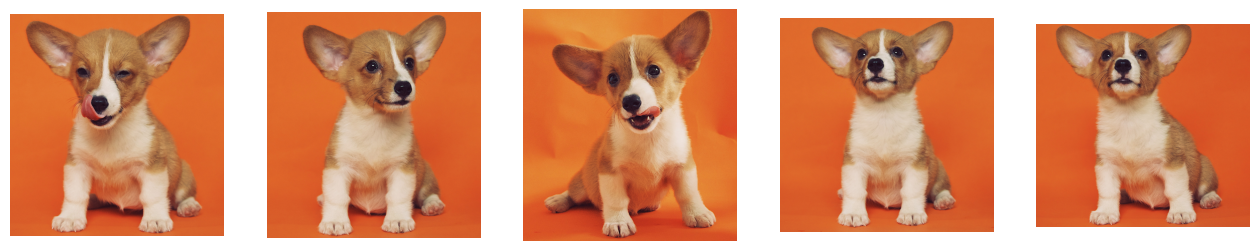

In [11]:
plot_images(instance_images)

**Class images**:

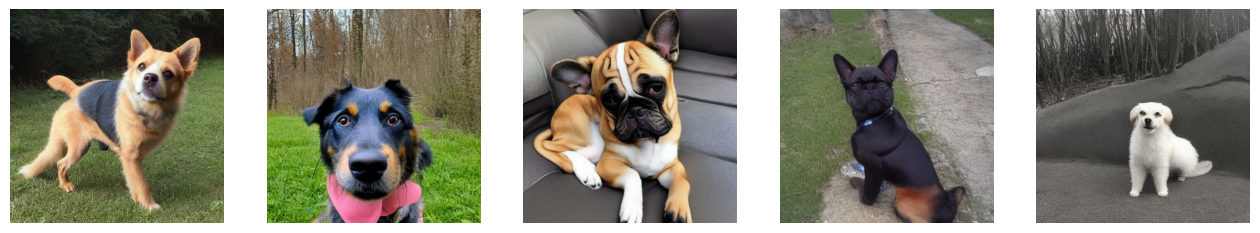

In [12]:
plot_images(class_images)

## Prepare datasets

Dataset preparation includes two stages: (1): preparing the captions, (2) processing the
images.

### Prepare the captions

In [13]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

instance_len = instance_images.cardinality() #5
class_len = class_images.cardinality() # 200
ds_len = instance_len * (class_len // instance_len)

instance_images = instance_images.repeat(class_len // instance_len)
class_images = class_images.take(ds_len)

In [14]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

# We just repeat the prompts / captions per images.
unique_id = "sks"
class_label = "dog"

instance_prompt = f"a photo of {unique_id} {class_label}"
class_prompt = f"a photo of {class_label}"

# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
padding_token = 49407
max_prompt_length = 77

# Load the tokenizer.
tokenizer = keras_cv.models.stable_diffusion.SimpleTokenizer()

# Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [padding_token] * (max_prompt_length - len(tokens))
    return tokens

tokenized_instance_prompt = process_text(instance_prompt)
tokenized_class_prompt = process_text(class_prompt)

instance_prompt_ds = tf.data.Dataset.from_tensor_slices([tokenized_instance_prompt]).repeat(ds_len)
class_prompt_ds = tf.data.Dataset.from_tensor_slices([tokenized_class_prompt]).repeat(ds_len)

Next, we embed the prompts to save some compute.

## Prepare the images

In [15]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

resolution = 512
auto = tf.data.AUTOTUNE

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(resolution, resolution),
        keras_cv.layers.RandomFlip(),
        keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)

def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (resolution, resolution))
    return image, tokenized_text


def apply_augmentation(image_batch, tokenized_texts):
    return augmenter(image_batch), tokenized_texts


def prepare_dict(instance_only=True):
    def fn(image_batch, tokenized_texts):
        if instance_only:
            batch_dict = {
                "instance_images": image_batch,
                "instance_texts": tokenized_texts,
            }
            return batch_dict
        else:
            batch_dict = {
                "class_images": image_batch,
                "class_texts": tokenized_texts,
            }
            return batch_dict

    return fn


def assemble_dataset(
    image_ds, tokenized_ds, instance_only=True, batch_size=1
):
    dataset = tf.data.Dataset.zip((image_ds, tokenized_ds))
    dataset = dataset.shuffle(5, reshuffle_each_iteration=True)
    dataset = dataset.map(process_image, num_parallel_calls=auto)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=auto)

    prepare_dict_fn = prepare_dict(instance_only=instance_only)
    dataset = dataset.map(prepare_dict_fn, num_parallel_calls=auto)
    return dataset

## Assemble dataset

In [16]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

BATCH_SIZE = 1

instance_dataset = assemble_dataset(
    instance_images,
    instance_prompt_ds,
    batch_size=BATCH_SIZE,
)
class_dataset = assemble_dataset(
    class_images,
    class_prompt_ds,
    instance_only=False,
    batch_size=BATCH_SIZE,
)
train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

## Check shapes

Now that the dataset has been prepared, let's quickly check what's inside it.

In [17]:
for d in train_dataset.take(1):
    for idx in range(len(d)):
        print(d[idx].keys())
        for key in d[idx].keys():
            print(f"shape of {key:15s}: {d[idx][key].shape}")

dict_keys(['instance_images', 'instance_texts'])
shape of instance_images: (1, 512, 512, 3)
shape of instance_texts : (1, 77)
dict_keys(['class_images', 'class_texts'])
shape of class_images   : (1, 512, 512, 3)
shape of class_texts    : (1, 77)


During training, we make use of these keys to gather the images and text embeddings and
concat them accordingly.

## DreamBooth training loop

Our DreamBooth training loop is very much inspired by
[this script](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py)
provided by the Diffusers team at Hugging Face. However, there is an important
difference to note. We only fine-tune the UNet (the model responsible for predicting
noise) and don't fine-tune the text encoder in this example. If you're looking for an
implementation that also performs the additional fine-tuning of the text encoder, refer
to [this repository](https://github.com/sayakpaul/dreambooth-keras/).

In [18]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

class DreamBoothTrainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py

    def __init__(
        self,
        sd_model,
        noise_scheduler,
        max_prompt_length=77,  # Default is 77
        use_mixed_precision=False,
        prior_loss_weight=1.0,
        max_grad_norm=1.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.sd_model = sd_model
        self.noise_scheduler = noise_scheduler
        self.max_prompt_length = max_prompt_length
        self.use_mixed_precision = use_mixed_precision
        self.prior_loss_weight = prior_loss_weight
        self.max_grad_norm = max_grad_norm

        self.diffusion_model = sd_model.diffusion_model
        self.text_encoder = sd_model.text_encoder

        self.image_encoder = tf.keras.Model(
            sd_model.image_encoder.input,
            sd_model.image_encoder.layers[-2].output,
        )
        self.image_encoder.trainable = False

    def compile(self, diffusion_optimizer, text_encoder_optimizer, loss):
        super().compile(loss=loss)
        self.diffusion_optimizer = diffusion_optimizer
        self.text_encoder_optimizer = text_encoder_optimizer
        
    def train_step(self, inputs):
        instance_batch = inputs[0]
        class_batch = inputs[1]

        instance_images = instance_batch["instance_images"]
        instance_text = instance_batch["instance_texts"]
        class_images = class_batch["class_images"]
        class_text = class_batch["class_texts"]

        images = tf.concat([instance_images, class_images], 0)
        tokenized_texts = tf.concat([instance_text, class_text], 0)
        batch_size = tf.shape(images)[0]
        POS_IDS = tf.convert_to_tensor(
            [list(range(max_prompt_length))], dtype=tf.int32
        )

        with tf.GradientTape(persistent=True) as tape:
            embedded_texts = self.text_encoder(
                [tokenized_texts, POS_IDS], training=True
            )

            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(
                self.image_encoder(images, training=False)
            )
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t),
                timesteps,
                fn_output_signature=tf.float32,
            )
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, embedded_texts],
                training=True,
            )
            loss = self.compute_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the text encoder and diffusion model.
        text_trainable_vars = self.text_encoder.trainable_variables
        diffusion_trainable_vars = self.diffusion_model.trainable_variables
        # trainable_vars = text_trainable_vars + diffusion_trainable_vars
        
        text_gradients = tape.gradient(loss, text_trainable_vars)
        diffusion_gradients = tape.gradient(loss, diffusion_trainable_vars)

        if self.use_mixed_precision:
            text_gradients = self.optimizer.get_unscaled_gradients(text_gradients)
            diffusion_gradients = self.optimizer.get_unscaled_gradients(diffusion_gradients)
        text_gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in text_gradients]
        diffusion_gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in diffusion_gradients]

        self.text_encoder_optimizer.apply_gradients(zip(text_gradients, text_trainable_vars))
        self.diffusion_optimizer.apply_gradients(zip(diffusion_gradients, diffusion_trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def compute_loss(self, target, model_pred):
        # Chunk the noise and model_pred into two parts and compute the loss
        # on each part separately.
        # Since the first half of the inputs has instance samples and the second half
        # has class samples, we do the chunking accordingly.
        model_pred, model_pred_prior = tf.split(
            model_pred, num_or_size_splits=2, axis=0
        )
        target, target_prior = tf.split(target, num_or_size_splits=2, axis=0)

        # Compute instance loss.
        loss = self.compiled_loss(target, model_pred)

        # Compute prior loss.
        prior_loss = self.compiled_loss(target_prior, model_pred_prior)

        # Add the prior loss to the instance loss.
        loss = loss + self.prior_loss_weight * prior_loss
        return loss

    def save_weights(
        self, filepath, overwrite=True, save_format=None, options=None
    ):
        # Overriding this method will allow us to customize which weights to save.
        # In this case, it will checkpoint the `diffusion_model` and `text_encoder`.
        self.diffusion_model.save_weights(
            filepath=f"{filepath}diffusion",
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

        self.text_encoder.save_weights(
            filepath=f"{filepath}text_encoder",
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

## Trainer initialization

In [19]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

def build_trainer(
    diffusion_learning_rate,
    text_learning_rate,
    diffusion_beta_1=0.9,
    diffusion_beta_2=0.999,
    text_beta_1=0.9,
    text_beta_2=0.999,
    diffusion_weight_decay=(1e-2,),
    text_weight_decay=(1e-2,),
    epsilon = 1e-08,
    use_mp=True # Set it to False if you're not using a GPU with tensor cores.
):
    if use_mp:
        tf.keras.mixed_precision.set_global_policy("mixed_float16")

    dreambooth_model = keras_cv.models.StableDiffusionV2(
        img_width=resolution, img_height=resolution, jit_compile=True
    )

    dreambooth_trainer = DreamBoothTrainer(
        sd_model=dreambooth_model,
        noise_scheduler=keras_cv.models.stable_diffusion.NoiseScheduler(),
        use_mixed_precision=use_mp,
    )

    diffusion_optimizer = tf.keras.optimizers.AdamW(
        learning_rate=diffusion_learning_rate,
        weight_decay=diffusion_weight_decay,
        beta_1=diffusion_beta_1,
        beta_2=diffusion_beta_2,
        epsilon=epsilon,
    )

    text_encoder_optimizer = tf.keras.optimizers.AdamW(
        learning_rate=text_learning_rate,
        weight_decay=text_weight_decay,
        beta_1=text_beta_1,
        beta_2=text_beta_2,
        epsilon=epsilon,
    )

    dreambooth_trainer.compile(
        diffusion_optimizer=diffusion_optimizer, 
        text_encoder_optimizer=text_encoder_optimizer,
        loss="mse")
    
    return dreambooth_trainer

### Construct callbacks

In [20]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

class ImageGenCallback(tf.keras.callbacks.Callback):
    def __init__(self, tensorboard_path):
        self.tensorboard_path = tensorboard_path
    
    def log_image(self, prefix, step):
        prompt = f"A photo of {unique_id} {class_label} in a car"
        num_imgs_to_gen = 3

        images_dreamboothed = self.model.sd_model.text_to_image(
            prompt, batch_size=num_imgs_to_gen
        )
        logdir = f"{self.tensorboard_path}images"
        file_writer = tf.summary.create_file_writer(logdir)

        with file_writer.as_default():
            tf.summary.image(
                f"{prefix}: '{prompt}'",
                images_dreamboothed,
                step=step,
            )

    def on_train_begin(self, logs=None):
        prefix = "0_Initial Model"
        self.log_image(prefix, step=0)

    def on_epoch_end(self, epoch, logs=None):
        prefix = f"{epoch+1}_Epoch {epoch+1}"
        self.log_image(prefix, step=epoch+1)

def construct_tb_callbacks(tensorboard_path):

    tb_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_path,
        write_graph=False,
    )
    return [tb_callback, ImageGenCallback(tensorboard_path)]

## Train!

We first calculate the number of epochs, we need to train for.

In [21]:
%%write_and_run -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

MAX_TRAIN_STEP = 1000

num_update_steps_per_epoch = ds_len // BATCH_SIZE
epochs = math.ceil(MAX_TRAIN_STEP / num_update_steps_per_epoch)

print(f"Training for {epochs} epochs.")

Training for 5 epochs.


We'll onstruct the trainer, and train the model as usual, and save the trained weights so that we can retrieve later.

In [22]:
%%writefile -a {TRAINING_APP_FOLDER}/dreambooth_trainer.py

dreambooth_trainer= build_trainer(
    diffusion_learning_rate = 6e-6,
    text_learning_rate = 6e-7,
)

tensorboard_path = os.getenv("AIP_TENSORBOARD_LOG_DIR")

dreambooth_trainer.fit(
    train_dataset,
    epochs=epochs,
    callbacks=construct_tb_callbacks(tensorboard_path),
)

dreambooth_trainer.save_weights(os.getenv("AIP_CHECKPOINT_DIR"))

Appending to dreambooth_model/dreambooth_trainer.py


### Local Training (Only if A100 GPU is attached to your machine!)
If your machine has an A100 GPU, you can remove the comment out in the cell below and run local training.<br>
If not, you can go to the next section and dispatch a Vertex AI training job!


In [38]:
# output_base_dir = "dreambooth_outputs"
# tensorboard_path = f"{output_base_dir}/logs/"

# !rm -rf {output_base_dir}
# os.makedirs(output_base_dir)

# dreambooth_trainer= build_trainer(
#     diffusion_learning_rate = 6e-6,
#     text_learning_rate = 6e-7,
# )

# %load_ext tensorboard
# %tensorboard --logdir {tensorboard_path}

# dreambooth_trainer.fit(
#     train_dataset,
#     epochs=epochs,
#     callbacks=construct_tb_callbacks(tensorboard_path),
# )

# os.makedirs(f"{output_base_dir}/checkpoints")
# dreambooth_trainer.save_weights(f"{output_base_dir}/checkpoints/")

### Cloud Training

In [27]:
%%writefile {TRAINING_APP_FOLDER}/Dockerfile
FROM us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-12.py310:latest
RUN pip install keras_cv==0.5.1 --upgrade --quiet

COPY . /code

WORKDIR /code

ENTRYPOINT ["python3", "dreambooth_trainer.py"]

Overwriting dreambooth_model/Dockerfile


In [28]:
IMAGE_NAME = "dreambooth_trainer"

!gcloud builds submit --tag gcr.io/{PROJECT}/{IMAGE_NAME} {TRAINING_APP_FOLDER}

Creating temporary tarball archive of 4 file(s) totalling 27.5 KiB before compression.
Uploading tarball of [dreambooth_model] to [gs://takumiohym-sandbox_cloudbuild/source/1692993818.404162-677f32086694429399804121aa7b4e7d.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/takumiohym-sandbox/locations/global/builds/58a49a2b-f25b-4796-9649-5f28bdb47f14].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/58a49a2b-f25b-4796-9649-5f28bdb47f14?project=237937020997 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "58a49a2b-f25b-4796-9649-5f28bdb47f14"

FETCHSOURCE
Fetching storage object: gs://takumiohym-sandbox_cloudbuild/source/1692993818.404162-677f32086694429399804121aa7b4e7d.tgz#1692993818654993
Copying gs://takumiohym-sandbox_cloudbuild/source/1692993818.404162-677f32086694429399804121aa7b4e7d.tgz#1692993818654993...
/ [1 files][  5.4 KiB/  5.4 KiB]                                                
Oper

In [29]:
import time

from google.cloud import aiplatform

TRAIN_CONTAINER_URI = f"gcr.io/{PROJECT}/dreambooth_trainer"

TRAIN_MACHINE_TYPE = "a2-highgpu-1g"
TRAIN_ACCELERATOR_TYPE = "NVIDIA_TESLA_A100"
TRAIN_NUM_GPU = 1

RESOLUTION = 512
REGION = "us-central1"

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": TRAIN_MACHINE_TYPE,
            "accelerator_type": TRAIN_ACCELERATOR_TYPE,
            "accelerator_count": TRAIN_NUM_GPU,
        },
        "replica_count": 1,
        "disk_spec": {
            "boot_disk_type": "pd-ssd",
            "boot_disk_size_gb": 500,
        },
        "container_spec": {
            "image_uri": TRAIN_CONTAINER_URI,
            "command": [],
        },
    }
]

Since A100 GPU is scarce, the training execution command would return errors frequently. You can add error handling and automatic retry like below, you can 

Training takes ~30 minutes with A100 GPU.

**If you're not luck enough to get A100 GPU, please feel free to skip this cell.
We already run the training for you in the same setup, and saved the result. You can check it in the next section.**

In [ ]:
def run_cloud_train(tries=1):
    for i in range(tries):
        try:
            TIMESTAMP = time.strftime("%Y%m%d_%H%M%S")
            global JOB_NAME
            JOB_NAME = f"dreambooth_training_{TIMESTAMP}"

            train_job = aiplatform.CustomJob(
                display_name=JOB_NAME,
                project=PROJECT,
                location=REGION,
                worker_pool_specs=worker_pool_specs,
                base_output_dir=f"gs://{PROJECT}/dreambooth_outputs/{JOB_NAME}",
                staging_bucket=f"gs://{PROJECT}",
            )

            train_job.run()

            retur

        except RuntimeError as e:
            if i < tries - 1:  # i is zero indexed
                print(f"Job Failed because of {e}.")
                print(f"Retry: {i+1}")
                continue
            else:
                raise
        break


run_cloud_train(tries=50)

## Check Training Result

Now let's take a look at the result!

In [31]:
# Replace the path to your bucket (second line) if you could run the training with A100.
output_base_dir = "gs://asl-public/model_checkpoints/dreambooth_trained"
# output_base_dir = f"gs://{PROJECT}/dreambooth_outputs/{JOB_NAME}"

Let's check how fine-tuning went using tensorboard!

In [32]:
%load_ext tensorboard
%tensorboard --logdir {output_base_dir}/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Now we load the checkpoint of the fine-tuned model and 

In [33]:
# Initialize a new Stable Diffusion model.
dreambooth_model = keras_cv.models.StableDiffusionV2(
    img_width=resolution, img_height=resolution, jit_compile=True
)
dreambooth_model.diffusion_model.load_weights(
    f"{output_base_dir}/checkpoints/diffusion"
)
dreambooth_model.text_encoder.load_weights(
    f"{output_base_dir}/checkpoints/text_encoder"
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL++-M license at https://github.com/Stability-AI/stablediffusion/blob/main/LICENSE-MODEL


In [34]:
def plot_inference(images, title=None):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        if title is not None:
            plt.title(title)
        plt.imshow(images[i])
        plt.axis("off")

50/50 [==============================] - 43s 131ms/step


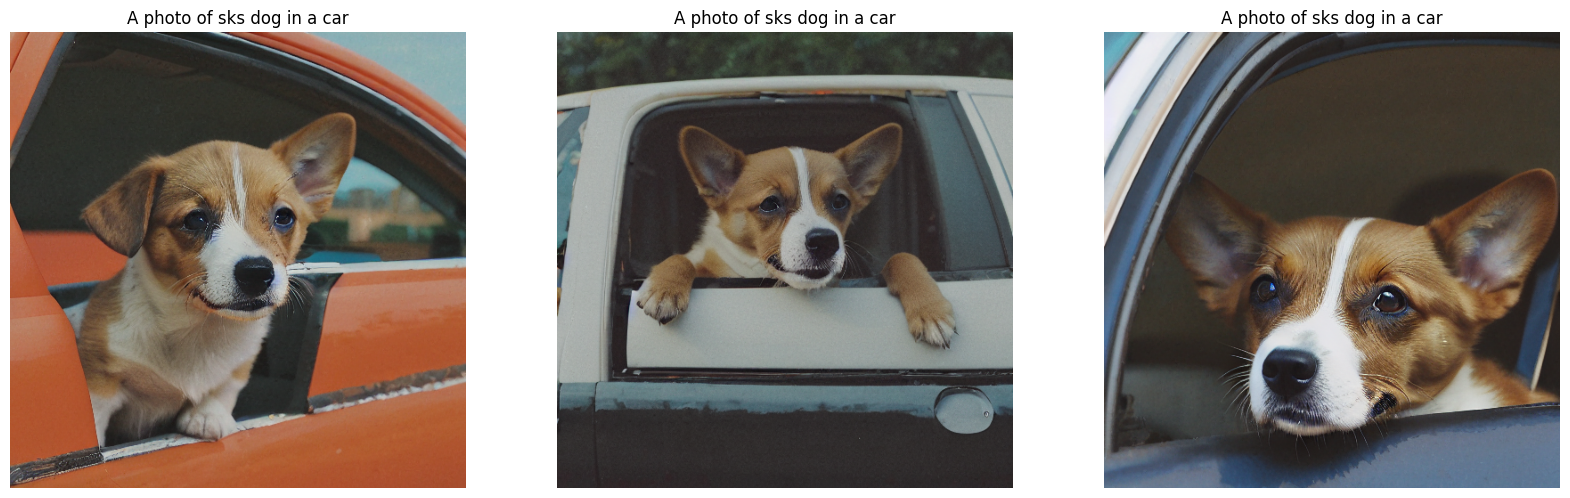

In [35]:
# Note how the unique identifier and the class have been used in the prompt.
prompt = f"A photo of {unique_id} {class_label} in a car"
num_imgs_to_gen = 3

images_dreamboothed = dreambooth_model.text_to_image(
    prompt, batch_size=num_imgs_to_gen
)
plot_inference(images_dreamboothed, prompt)

50/50 [==============================] - 6s 129ms/step


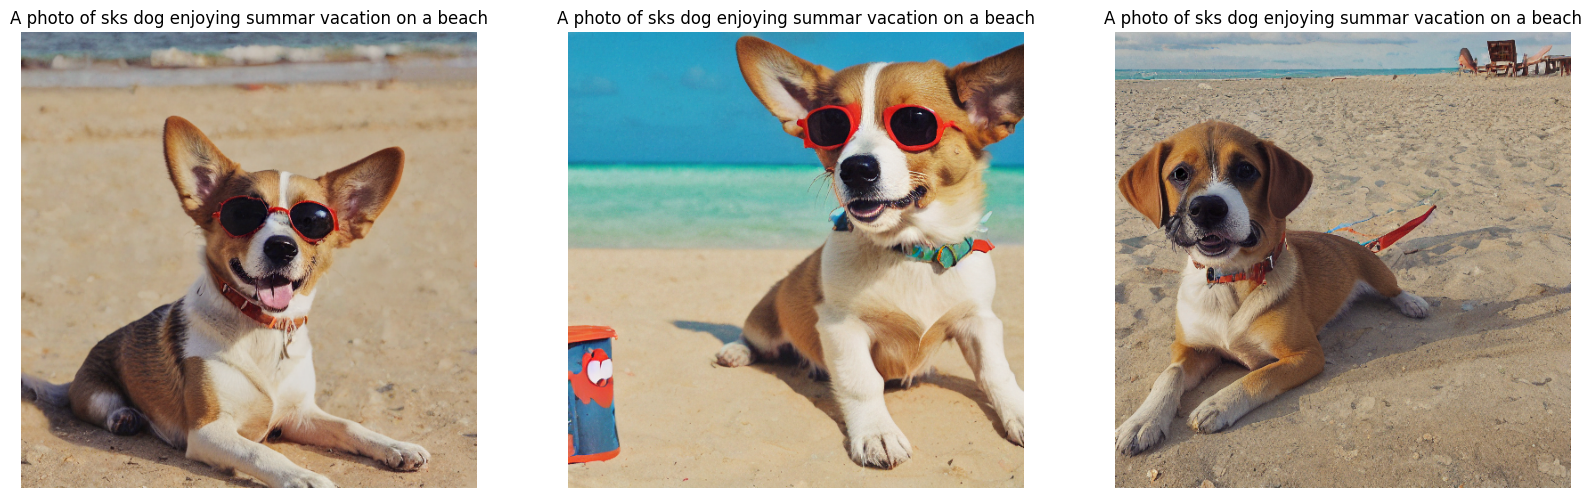

In [36]:
# Note how the unique identifier and the class have been used in the prompt.
prompt = (
    f"A photo of {unique_id} {class_label} enjoying summar vacation on a beach"
)
num_imgs_to_gen = 3

images_dreamboothed = dreambooth_model.text_to_image(
    prompt, batch_size=num_imgs_to_gen
)
plot_inference(images_dreamboothed, prompt)

50/50 [==============================] - 7s 132ms/step


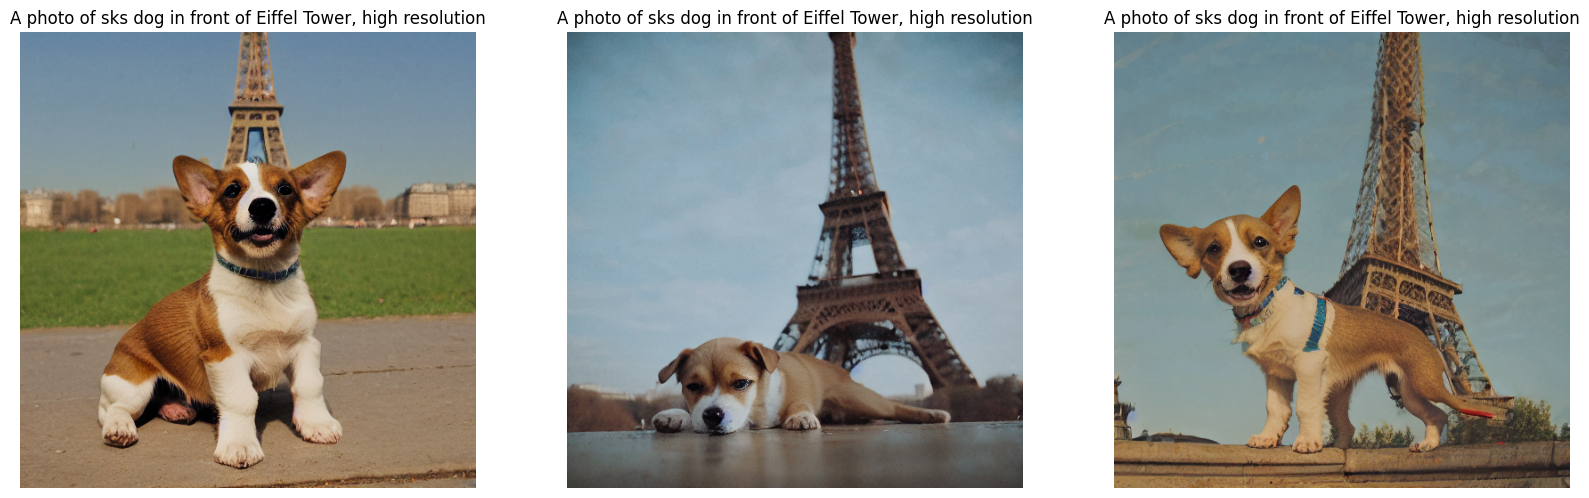

In [37]:
prompt = f"A photo of {unique_id} {class_label} in front of Eiffel Tower, high resolution"

images_dreamboothed = dreambooth_model.text_to_image(
    prompt, batch_size=num_imgs_to_gen
)
plot_inference(images_dreamboothed, prompt)

Feel free to experiment with different prompts (don't forget to add the unique identifer
and the class label!) to see how the results change. We welcome you to check out our
codebase and more experimental results
[here](https://github.com/sayakpaul/dreambooth-keras#results). You can also read
[this blog post](https://huggingface.co/blog/dreambooth) to get more ideas.

## Acknowledgements
